In [1]:
pip install -q seaborn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [20]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [50]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [51]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [52]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  plt.show()

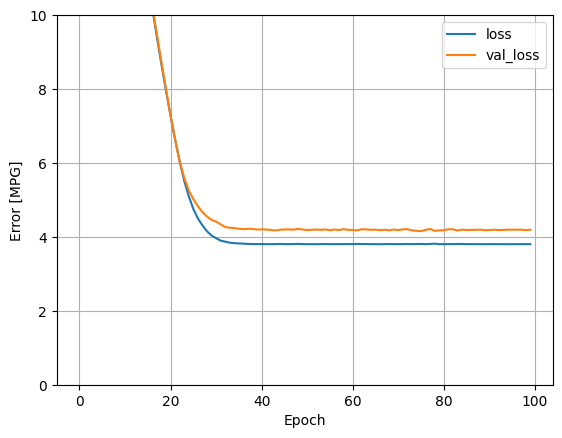

In [54]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Normalization, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
horsepower_model = Sequential([
    horsepower_normalizer,
    Dense(1)
])
horsepower_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')
history = horsepower_model.fit(horsepower, train_labels, epochs=100, verbose=0, validation_split=0.2)
plot_loss(history)

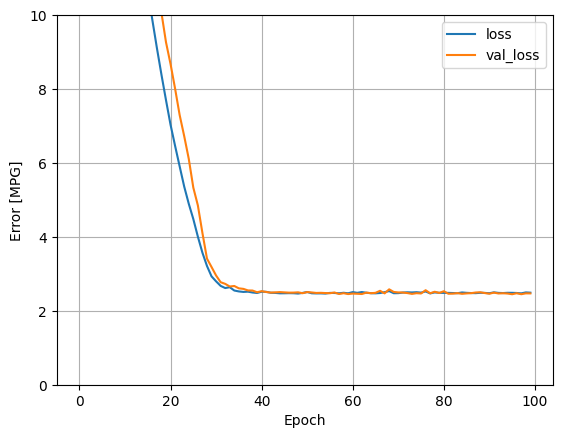

In [55]:
normalizer = Normalization(axis=-1)
normalizer.adapt(train_features)
linear_model = Sequential([
    normalizer,
    Dense(1)
])
linear_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')
linear_history = linear_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)
plot_loss(linear_history)

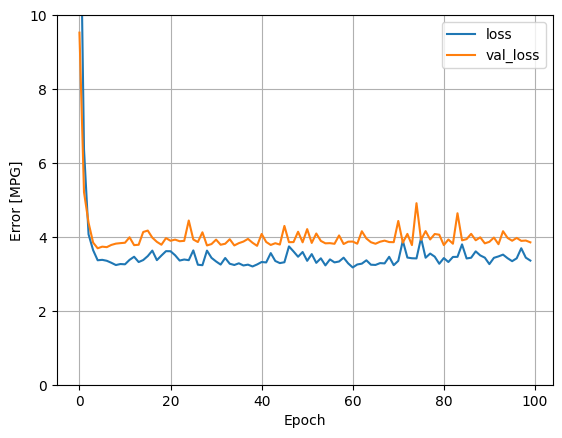

In [58]:
horsepower_dnn_model = Sequential([
    horsepower_normalizer,
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
horsepower_dnn_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')
horsepower_dnn_history = horsepower_dnn_model.fit(train_features['Horsepower'], train_labels, epochs=100, verbose=0, validation_split=0.2)
plot_loss(horsepower_dnn_history)

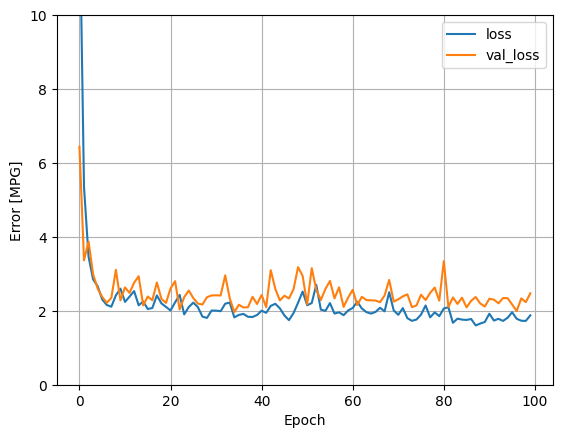

In [59]:
dnn_model = Sequential([
    normalizer,
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')
dnn_history = dnn_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)
plot_loss(dnn_history)

In [60]:
test_results = {}
test_results['horsepower-linear'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels, verbose=0)
test_results['linear'] = linear_model.evaluate(test_features, test_labels, verbose=0)
test_results['horsepower-dnn'] = horsepower_dnn_model.evaluate(test_features['Horsepower'], test_labels, verbose=0)
test_results['dnn'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower-linear,3.652096
linear,2.469066
horsepower-dnn,3.065529
dnn,2.797217


In [87]:
def plot_prediction(predictions):
    lims = [0, 50]
    plt.axes(aspect='equal')
    plt.scatter(test_labels, predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)
    plt.show()

    error = predictions - test_labels
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [MPG]')
    plt.ylabel('Count')
    plt.show()


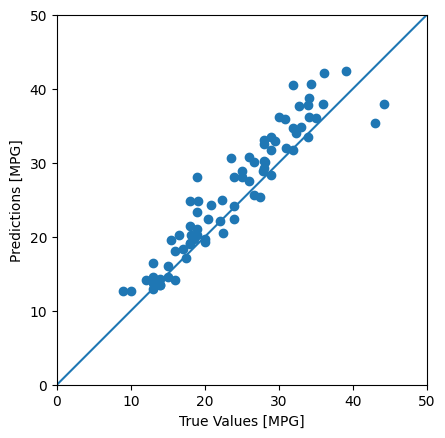

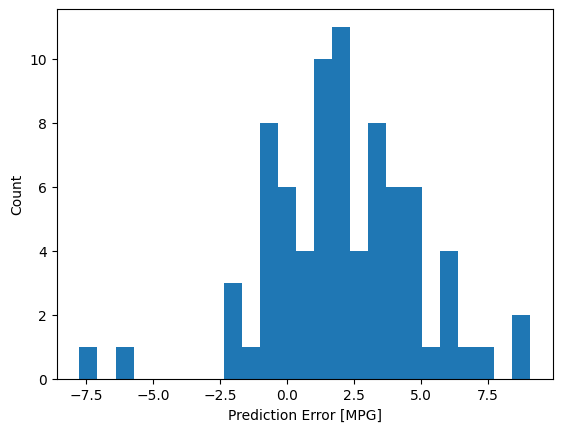

In [88]:
dnn_predictions = dnn_model.predict(test_features).flatten()
plot_prediction(dnn_predictions)